## Continuous Reactor Example 
### Simulation of a CSTR/PSR/WSR 

In this example we will illustrate how Cantera can be used to simulate a Continuously Stirred Tank Reactor (CSTR), also interchangeably referred to as a Perfectly Stirred Reactor or a Well Stirred Reactor, a Jet Stirred Reactor or a Longwell Reactor (there may well be more "aliases"). A cartoon of such a reactor is shown below

<img src="images/stirredReactorCartoon.png" alt="Cartoon of a Stirred Reactor" style="width: 300px;"/>

As the figure illustrates, this is an open system (unlike a Batch Reactor which is isolated). P, V and T are the reactor's pressure, volume and temperature respectively. The mass flow rate at which reactants come in is the same as that of the products which exit; and these stay in the reactor for a characteristic time $\tau$, called the *residence time*. This is a key quantity in sizing the reactor and is defined as follows:

\begin{equation*}
\tau = \frac{m}{\dot{m}}
\end{equation*}

where $m$ is the mass of the gas

In [1]:
from __future__ import division
from __future__ import print_function

import pandas as pd
import numpy as np
import time
import cantera as ct

print("Running Cantera version: {}".format(ct.__version__))

Running Cantera version: 2.5.0a2


### Import modules and set plotting defaults

In [2]:
%matplotlib notebook
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.style.use('seaborn-pastel')

plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['figure.autolayout'] = True

### Define the gas
In this example, we will work with $nC
_{7}H_{16}$/$O_{2}$/$He$ mixtures, for which experimental data can be found in the paper by [Zhang et al.](http://dx.doi.org/10.1016/j.combustflame.2015.08.001). We will use the same mechanism reported in the paper. It consists of 1268 species and 5336 reactions

In [3]:
gas = ct.Solution('data/galway.yaml')



**** WARNING ****
For species OHV, discontinuity in h/RT detected at Tmid = 1000
	Value computed using low-temperature polynomial:  53.6206
	Value computed using high-temperature polynomial: 53.5842


**** WARNING ****
For species CHV, discontinuity in h/RT detected at Tmid = 1000
	Value computed using low-temperature polynomial:  107.505
	Value computed using high-temperature polynomial: 107.348


### Define initial conditions
#### Inlet conditions for the gas and reactor parameters

In [4]:
# Inlet gas conditions
reactorTemperature = 925  # Kelvin
reactorPressure = 1.046138*ct.one_atm  # in atm. This equals 1.06 bars
concentrations = {'NC7H16': 0.005, 'O2': 0.0275, 'HE': 0.9675}
gas.TPX = reactorTemperature, reactorPressure, concentrations 

# Reactor parameters
residenceTime = 2  # s
reactorVolume = 30.5*(1e-2)**3  # m3

# Instrument parameters

# This is the "conductance" of the pressure valve and will determine its efficiency in 
# holding the reactor pressure to the desired conditions. 
pressureValveCoefficient = 0.01

# This parameter will allow you to decide if the valve's conductance is acceptable. If there
# is a pressure rise in the reactor beyond this tolerance, you will get a warning
maxPressureRiseAllowed = 0.01

#### Simulation parameters

In [5]:
# Simulation termination criterion
maxSimulationTime = 50  # seconds

### Reactor arrangement

We showed a cartoon of the reactor in the first figure in this notebook; but to actually simulate that, we need a few peripherals. A mass-flow controller upstream of the stirred reactor will allow us to flow gases in, and in-turn, a "reservoir" which simulates a gas tank is required to supply gases to the mass flow controller. Downstream of the reactor, we install a pressure regulator which allows the reactor pressure to stay within. Downstream of the regulator we will need another reservoir which acts like a "sink" or capture tank to capture all exhaust gases (even our simulations are environmentally friendly !). This arrangment is illustrated below

<img src="images/stirredReactorCanteraSimulation.png" alt="Cartoon of a Stirred Reactor" style="width: 600px;"/>

#### Initialize the stirred reactor and connect all peripherals

In [6]:
fuelAirMixtureTank = ct.Reservoir(gas)
exhaust = ct.Reservoir(gas)

stirredReactor = ct.IdealGasReactor(gas, energy='off', volume=reactorVolume)

massFlowController = ct.MassFlowController(upstream=fuelAirMixtureTank,
                                           downstream=stirredReactor,
                                           mdot=stirredReactor.mass/residenceTime)

pressureRegulator = ct.Valve(upstream=stirredReactor,
                             downstream=exhaust,
                             K=pressureValveCoefficient)

reactorNetwork = ct.ReactorNet([stirredReactor])

In [7]:
# Now compile a list of all variables for which we will store data
columnNames = [stirredReactor.component_name(item) for item in range(stirredReactor.n_vars)]
columnNames = ['pressure'] + columnNames

# Use the above list to create a DataFrame
timeHistory = pd.DataFrame(columns=columnNames)

In [8]:
# Start the stopwatch
tic = time.time()

# Set simulation start time to zero
t = 0
counter = 1
while t < maxSimulationTime:
    t = reactorNetwork.step()

    # We will store only every 10th value. Remember, we have 1200+ species, so there will be
    # 1200 columns for us to work with
    if(counter%10 == 0):
        # Extract the state of the reactor
        state = np.hstack([stirredReactor.thermo.P, stirredReactor.mass, 
                   stirredReactor.volume, stirredReactor.T, stirredReactor.thermo.X])
        
        # Update the dataframe
        timeHistory.loc[t] = state
    
    counter += 1

# Stop the stopwatch
toc = time.time()

print('Simulation Took {:3.2f}s to compute, with {} steps'.format(toc-tic, counter))

# We now check to see if the pressure rise during the simulation, a.k.a the pressure valve
# was okay
pressureDifferential = timeHistory['pressure'].max()-timeHistory['pressure'].min()
if(abs(pressureDifferential/reactorPressure) > maxPressureRiseAllowed):
    print("WARNING: Non-trivial pressure rise in the reactor. Adjust K value in valve")

Simulation Took 8.79s to compute, with 1153 steps


## Plot the results

As a test, we plot the mole fraction of $CO$ and see if the simulation has converged. If not, go back and adjust max. number of steps and/or simulation time

<IPython.core.display.Javascript object>


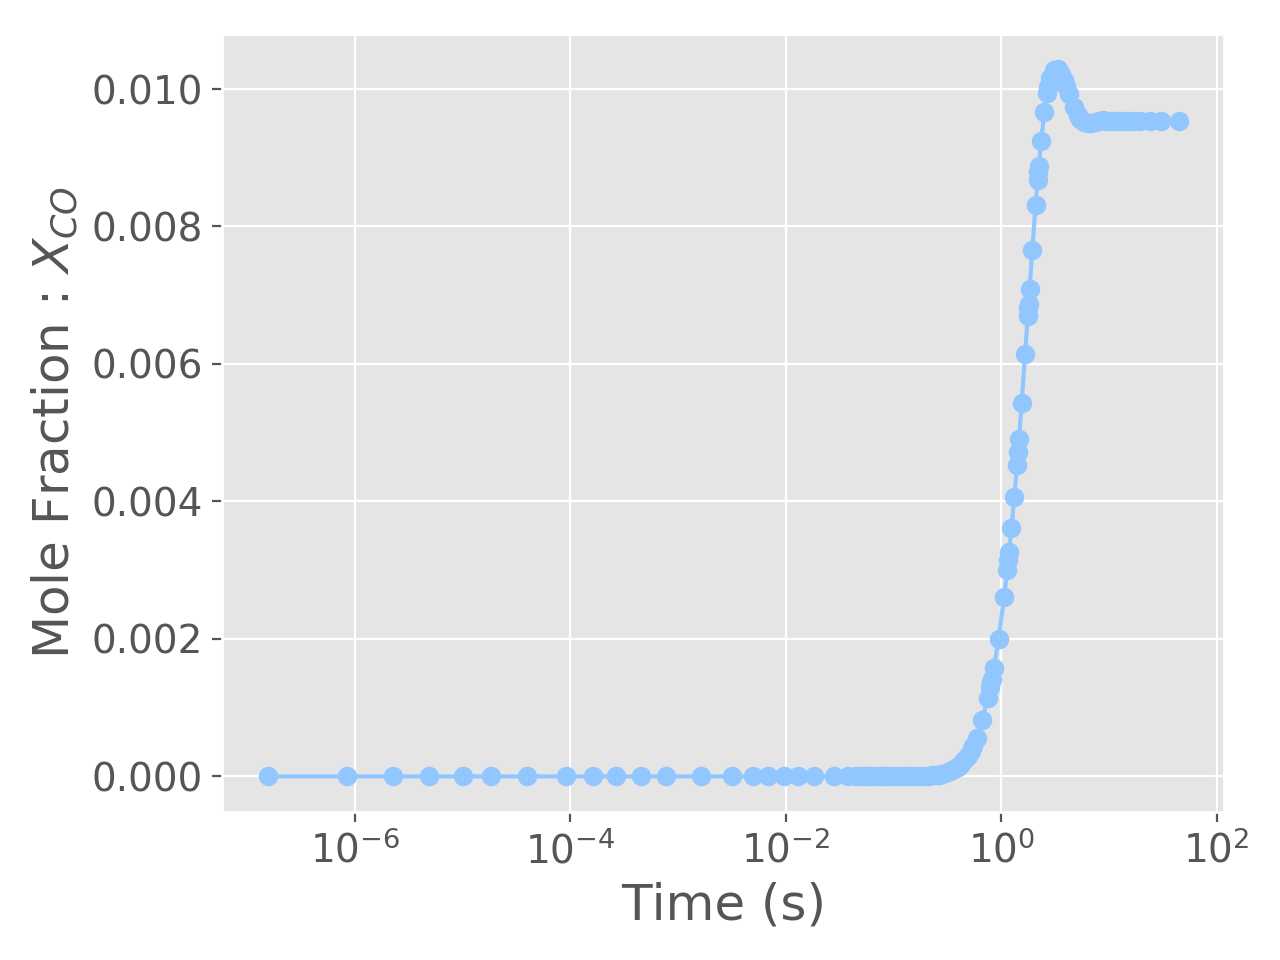

In [9]:
plt.figure()
plt.semilogx(timeHistory.index, timeHistory['CO'],'-o')
plt.xlabel('Time (s)')
plt.ylabel(r'Mole Fraction : $X_{CO}$');

## Illustration : Modeling experimental data
### Let us see if the reactor can reproduce actual experimental measurements

We first load the data. This is also supplied in the paper by [Zhang et al.](http://dx.doi.org/10.1016/j.combustflame.2015.08.001) as an excel sheet

In [10]:
expData = pd.read_csv('data/zhangExpData.csv')
expData.head()

,T,NC7H16,O2,CO,CO2
0,500,0.00507,0.0293,0.000000,0.000000
1,525,0.00492,0.0286,0.000000,0.000000
2,550,0.00466,0.0285,0.000000,0.000000
3,575,0.00416,0.0263,0.000243,0.000101
4,600,0.00355,0.0233,0.000968,0.000251


In [11]:
# Define all the temperatures at which we will run simulations. These should overlap
# with the values reported in the paper as much as possible
T = [650, 700, 750, 775, 825, 850, 875, 925, 950, 1075, 1100]

# Create a DataFrame to store values for the above points
tempDependence = pd.DataFrame(columns=timeHistory.columns)
tempDependence.index.name = 'Temperature'

Now we simply run the reactor code we used above for each temperature

In [12]:
inletConcentrations = {'NC7H16': 0.005, 'O2': 0.0275, 'HE': 0.9675}
concentrations = inletConcentrations

for temperature in T:
    # Re-initialize the gas
    reactorTemperature = temperature  # Kelvin
    reactorPressure = 1.046138*ct.one_atm  # in atm. This equals 1.06 bars
    reactorVolume = 30.5*(1e-2)**3  # m3

    gas.TPX = reactorTemperature, reactorPressure, inletConcentrations

    # Re-initialize the dataframe used to hold values
    timeHistory = pd.DataFrame(columns=columnNames)
    
    # Re-initialize all the reactors, reservoirs, etc.
    fuelAirMixtureTank = ct.Reservoir(gas)
    exhaust = ct.Reservoir(gas)
    
    # We will use concentrations from the previous iteration to speed up convergence
    gas.TPX = reactorTemperature, reactorPressure, concentrations
    
    stirredReactor = ct.IdealGasReactor(gas, energy='off', volume=reactorVolume)
    massFlowController = ct.MassFlowController(upstream=fuelAirMixtureTank,
                                               downstream=stirredReactor,
                                               mdot=stirredReactor.mass/residenceTime)
    pressureRegulator = ct.Valve(upstream=stirredReactor, 
                                 downstream=exhaust, 
                                 K=pressureValveCoefficient)
    reactorNetwork = ct.ReactorNet([stirredReactor])
    
    # Re-run the isothermal simulations
    tic = time.time()
    t = 0
    while t < maxSimulationTime:
        t = reactorNetwork.step()
        
    state = np.hstack([stirredReactor.thermo.P, 
                       stirredReactor.mass, 
                       stirredReactor.volume, 
                       stirredReactor.T, 
                       stirredReactor.thermo.X])

    toc = time.time()
    print('Simulation at T={}K took {:3.2f}s to compute'.format(temperature, toc-tic))
    
    concentrations = stirredReactor.thermo.X
    
    # Store the result in the dataframe that indexes by temperature
    tempDependence.loc[temperature] = state

Simulation at T=650K took 9.85s to compute
Simulation at T=700K took 11.86s to compute
Simulation at T=750K took 3.99s to compute
Simulation at T=775K took 5.76s to compute
Simulation at T=825K took 6.73s to compute
Simulation at T=850K took 6.59s to compute
Simulation at T=875K took 5.78s to compute
Simulation at T=925K took 6.62s to compute
Simulation at T=950K took 4.53s to compute
Simulation at T=1075K took 8.07s to compute
Simulation at T=1100K took 4.86s to compute


### Compare the model results with experimental data

<IPython.core.display.Javascript object>


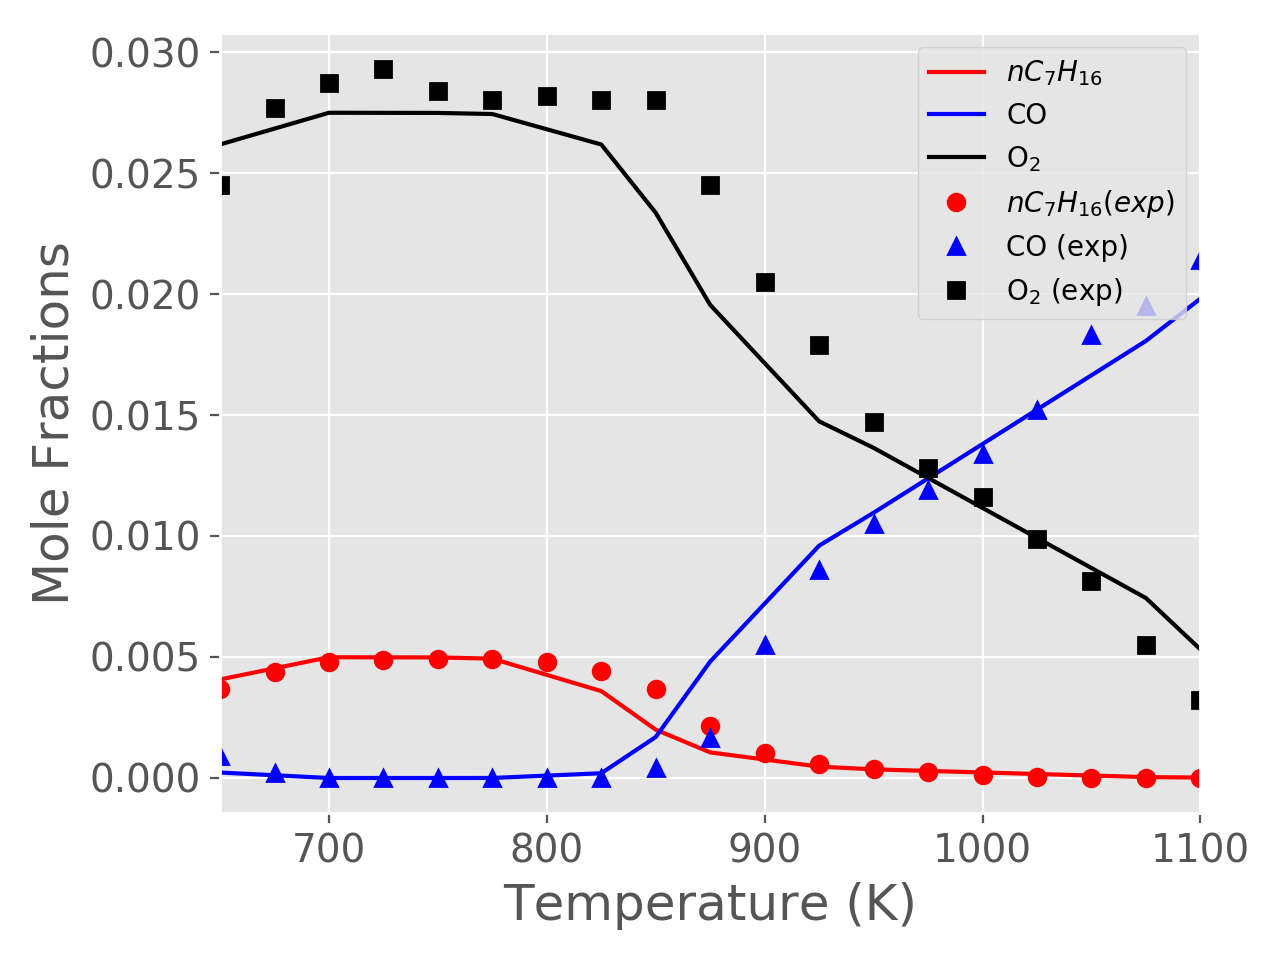

In [13]:
plt.figure()
plt.plot(tempDependence.index, tempDependence['NC7H16'], 'r-', label=r'$nC_{7}H_{16}$')
plt.plot(tempDependence.index, tempDependence['CO'], 'b-', label='CO')
plt.plot(tempDependence.index, tempDependence['O2'], 'k-', label='O$_{2}$')

plt.plot(expData['T'], expData['NC7H16'],'ro', label=r'$nC_{7}H_{16} (exp)$')
plt.plot(expData['T'], expData['CO'],'b^', label='CO (exp)')
plt.plot(expData['T'], expData['O2'],'ks', label='O$_{2}$ (exp)')

plt.xlabel('Temperature (K)')
plt.ylabel(r'Mole Fractions')

plt.xlim([650, 1100])
plt.legend(loc=1);